In [1]:
import pandas as pd

df = pd.read_csv('dailygroundnut.csv')

df

,Unnamed: 0,Datetime,AvgPrice
0,0,2011-01-01,3166.0
1,1,2011-01-02,2380.0
2,2,2011-01-03,4083.0
3,3,2011-01-04,4100.0
4,4,2011-01-05,4074.0
...,...,...,...
3602,3602,2024-02-21,8070.0
3603,3603,2024-02-22,8000.0
3604,3604,2024-02-23,8015.0
3605,3605,2024-02-24,6940.0


In [2]:
df = df[['Datetime', 'AvgPrice']]

In [3]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,AvgPrice
Datetime,
2011-01-01,3166.0
2011-01-02,2380.0
2011-01-03,4083.0
2011-01-04,4100.0
2011-01-05,4074.0


In [5]:
def create_features(df):
    """
    Create time series features based on time series index within the specified test size.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # Ensure that 'weekofyear' is computed within the test window
    df['weekofyear'] = (df.index - df.index[0]).days // 7 + 1  # Compute week of the year relative to the start of the data
    return df

df = create_features(df)

In [6]:
from pycaret.regression import *

s = setup(df, target='AvgPrice')

,Description,Value
0,Session id,563
1,Target,AvgPrice
2,Target type,Regression
3,Original data shape,"(3607, 8)"
4,Transformed data shape,"(3607, 8)"
5,Transformed train set shape,"(2524, 8)"
6,Transformed test set shape,"(1083, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [7]:
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,331.1880,268801.7812,518.4610,0.8945,0.0768,0.0524
1,316.1814,264910.6250,514.6947,0.8929,0.0753,0.0491
2,340.3289,314866.0938,561.1293,0.8897,0.0807,0.0527
3,330.7763,245706.0312,495.6874,0.9026,0.0746,0.0521
4,360.8292,315123.9062,561.3590,0.8789,0.0856,0.0575
5,367.5008,387194.7812,622.2498,0.8718,0.0973,0.0586
6,341.1058,297980.4062,545.8758,0.8920,0.0834,0.0540
7,328.5854,282581.4375,531.5839,0.8934,0.0788,0.0519
8,366.5205,365652.5000,604.6921,0.8627,0.0970,0.0607


In [8]:
print(xgboost)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=563, ...)


In [9]:
tuned_xgboost = tune_model(xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,313.3463,249917.7656,499.9178,0.9019,0.0721,0.0484
1,302.8354,230699.0312,480.3114,0.9067,0.0718,0.0473
2,314.2274,278307.6562,527.5487,0.9025,0.0754,0.0485
3,312.6715,209163.7344,457.3442,0.9171,0.0700,0.0498
4,352.4362,308723.6875,555.6291,0.8813,0.0843,0.0563
5,347.0755,340899.6562,583.8661,0.8872,0.0931,0.0558
6,323.8065,249600.4219,499.6003,0.9095,0.0755,0.0509
7,319.3515,261103.2344,510.9826,0.9015,0.0745,0.0496
8,345.0435,335647.6875,579.3511,0.8740,0.0946,0.0577


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
finalize_model(tuned_xgboost)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['dayofweek', 'quarter', 'month',
                                             'year', 'dayofyear', 'dayofmonth',
                                             'weekofyear'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 XGBRegressor(base_score...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=4,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=240, n_jobs=-1,
                              num_parallel_tree=None, random_state=563, ...))])

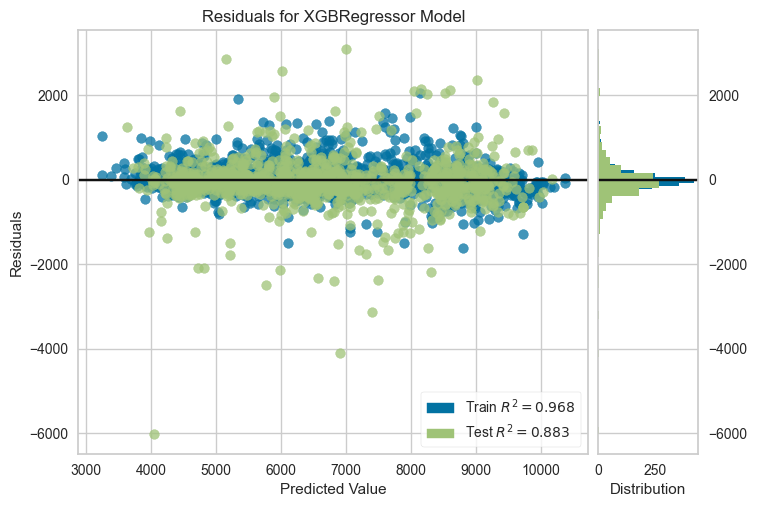

In [11]:

plot_model(tuned_xgboost)

In [12]:
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [13]:
predict_model(tuned_xgboost)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,336.8406,324578.2188,569.7176,0.8833,0.0903,0.0529


,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AvgPrice,prediction_label
Datetime,,,,,,,,,
2013-10-03,3,4,10,2013,276,3,144,4356.0,4477.055176
2021-04-29,3,2,4,2021,119,29,539,8440.0,8497.769531
2014-05-28,2,2,5,2014,148,28,178,5149.5,5046.878418
2019-06-11,1,2,6,2019,162,11,441,7350.0,7386.580566
2016-12-13,1,4,12,2016,348,13,311,5650.0,6424.172363
...,...,...,...,...,...,...,...,...,...
2023-11-29,2,4,11,2023,333,29,674,8962.0,8395.117188
2022-07-28,3,3,7,2022,209,28,604,9034.0,9008.515625
2021-10-09,5,4,10,2021,282,9,563,6100.0,7225.644043


In [17]:
# Extract feature importances
feature_importances = tuned_xgboost.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


ValueError: All arrays must be of the same length